# 🚀 Notebook Huấn luyện: Dự báo Doanh số Bugi bằng Prophet

**Mục tiêu:** Huấn luyện mô hình Prophet trên bộ dữ liệu tổng hợp (`10_sparkplug_dataset_final.csv`).

**Quy trình:**
1.  **Setup:** Cài đặt và nhập thư viện.
2.  **Tải & Khám phá:** Tải bộ dữ liệu đã tạo.
3.  **Tiền xử lý:** Xử lý NA, Scale dữ liệu, và "Shift" (dịch chuyển) features để chống rò rỉ.
4.  **Chia Train/Test:** Chia dữ liệu để kiểm tra mô hình.
5.  **Huấn luyện:** Cấu hình và `fit` mô hình Prophet với tất cả các yếu tố ảnh hưởng.
6.  **Đánh giá:** Chạy `predict` trên tập Test và xem các chỉ số (MAE, RMSE, MAPE).

In [ ]:
# --- SECTION 1: SETUP AND LIBRARY IMPORTS ---

# CÀI THƯ VIỆN (bật khi chạy trên Colab/VM sạch)
print("--- 1. Cài đặt/Nâng cấp thư viện Prophet ---")
!pip -q install prophet --upgrade

import warnings, sys
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

print("\n✅ Libraries imported successfully.")

--- 1. Cài đặt/Nâng cấp thư viện Prophet ---

✅ Libraries imported successfully.


In [ ]:
# --- SECTION 2: DATA LOADING AND INITIAL EXPLORATION ---

# === CẤU HÌNH ĐƯỜNG DẪN DỮ LIỆU ===
USE_DRIVE = True  # Đặt là False nếu bạn tải file lên Colab thủ công

if USE_DRIVE:
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        print("✅ Google Drive mounted.")

        # Giả sử bạn đã lưu file vào thư mục này
        BASE_DRIVE_PATH = "/content/drive/MyDrive/Denso/Data_Structure"
    except Exception as e:
        print(f"⚠️ Không thể kết nối Google Drive: {e}. Giả định file ở local.")
        USE_DRIVE = False
        BASE_DRIVE_PATH = "/" # Đường dẫn local
else:
    BASE_DRIVE_PATH = "/" # Đường dẫn local

# Đường dẫn dữ liệu
DATA_PATH = os.path.join(BASE_DRIVE_PATH, "10_sparkplug_dataset_final.csv")
print(f"Attempting to load data from: {DATA_PATH}")

# === ĐỌC DỮ LIỆU ===
try:
    df = pd.read_csv(DATA_PATH)
    print("✅ Data loaded successfully.")
except FileNotFoundError:
    print(f"❌ LỖI: Không tìm thấy file dữ liệu tại {DATA_PATH}.")
    print("Vui lòng chạy notebook TẠO DỮ LIỆU (PART 1-5) trước.")
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}")


# Chuẩn hoá kiểu thời gian và sắp xếp
if "ds" not in df.columns or "y" not in df.columns:
    raise ValueError("File needs columns 'ds' (datetime) and 'y' (target).")

df["ds"] = pd.to_datetime(df["ds"])
df = df.sort_values("ds").reset_index(drop=True)

print("\n--- Data Overview ---")
print(f"Rows: {len(df)} | Date Range: {df['ds'].min().date()} → {df['ds'].max().date()}")
print("\n--- First 5 Rows ---")
display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted.
Attempting to load data from: /content/drive/MyDrive/Denso/Data_Structure/10_sparkplug_dataset_final.csv
✅ Data loaded successfully.

--- Data Overview ---
Rows: 202 | Date Range: 2022-01-03 → 2025-11-10

--- First 5 Rows ---


,ds,year,week,month,quarter,y,y_oem,y_aftermarket,y_true,stockout_flag,...,new_ice_and_hybrid_sales,total_ice_and_hybrid_on_road,weather_impact_score,logistics_risk_score,own_price_oem,own_price_aftermarket,comp_price_aftermarket,promo_flag,promo_depth,holiday_flag
0,2022-01-03,2022,1,1,1,3306,3306,0,3306,0,...,35803,4000000,0,5,60000,110000,109724,0,0.0,0
1,2022-01-10,2022,2,1,1,4202,3408,794,4202,0,...,36185,4004263,0,0,60000,110012,109830,0,0.0,0
2,2022-01-17,2022,3,1,1,4235,3437,798,4235,0,...,36568,4008610,0,0,60000,110001,110071,0,0.0,0
3,2022-01-24,2022,4,1,1,4948,3385,1563,4948,0,...,36950,4013040,0,0,60000,109965,109937,0,0.0,1
4,2022-01-31,2022,5,1,1,3474,3431,43,3474,0,...,37331,4017555,0,3,60000,109947,109261,0,0.0,1


--- Preprocessing Steps ---
Tìm thấy 20 features để dùng làm regressors:
['year', 'week', 'month', 'quarter', 'stockout_flag', 'gdp_growth', 'cpi', 'gas_price', 'total_new_vehicle_sales', 'bev_penetration_rate', 'new_ice_and_hybrid_sales', 'total_ice_and_hybrid_on_road', 'weather_impact_score', 'logistics_risk_score', 'own_price_oem', 'own_price_aftermarket', 'comp_price_aftermarket', 'promo_flag', 'promo_depth', 'holiday_flag']
Handling NA values using ffill then bfill...
Scaling numeric regressors using StandardScaler...
Shifting regressors backward by 1 week to prevent data leakage...
Removed 1 row due to shifting.
✅ Preprocessing and feature engineering complete.

--- Target Variable (y) Over Time (After Preprocessing) ---


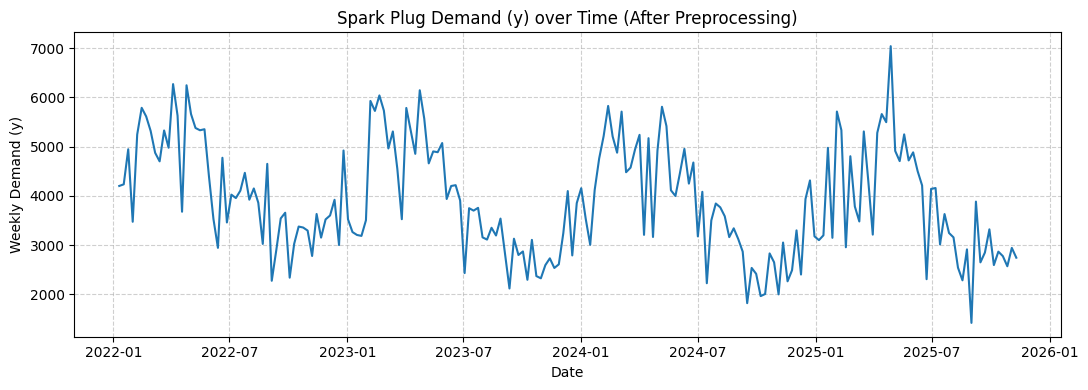

In [ ]:
# --- SECTION 3: DATA PREPROCESSING & FEATURE ENGINEERING ---

print("--- Preprocessing Steps ---")
# Bỏ trùng (nếu có)
df = df.drop_duplicates(subset=["ds"], keep="last").reset_index(drop=True)

# Xác định toàn bộ features: mọi cột ngoại trừ các cột mục tiêu và 'ds'
all_cols = df.columns.tolist()
TARGETS = ['y', 'y_oem', 'y_aftermarket', 'y_true']
FEATURES = [c for c in all_cols if c not in TARGETS and c != 'ds']

if len(FEATURES) == 0:
    print("⚠️ Không tìm thấy feature nào. Model sẽ chạy dự báo đơn biến.")
else:
    print(f"Tìm thấy {len(FEATURES)} features để dùng làm regressors:")
    print(FEATURES)

# Xử lý NA (Prophet không nhận NaN)
# Chúng ta dùng ffill (điền tiếp) rồi bfill (điền lùi)
print("Handling NA values using ffill then bfill...")
for col in FEATURES + ["y"]: # Chỉ cần xử lý 'y' chính
    if df[col].isna().any():
        df[col] = df[col].ffill().bfill()

# Khởi tạo StandardScaler
scaler = StandardScaler()
# Scale tất cả các feature (giúp mô hình hội tụ tốt hơn)
print("Scaling numeric regressors using StandardScaler...")
df[FEATURES] = scaler.fit_transform(df[FEATURES])

# --- CHỐNG RÒ RỈ DỮ LIỆU (DATA LEAKAGE) ---
# Dịch chuyển (shift) tất cả các feature lùi lại 1 tuần
# Logic: Khi dự báo Tuần T, ta chỉ được dùng dữ liệu của Tuần T-1
print("Shifting regressors backward by 1 week to prevent data leakage...")
df[FEATURES] = df[FEATURES].shift(1)

# Xóa dòng đầu tiên (giờ đã là NaN do bị shift)
initial_rows = len(df)
df = df.dropna().reset_index(drop=True)
print(f"Removed {initial_rows - len(df)} row due to shifting.")
print("✅ Preprocessing and feature engineering complete.")

# Vẽ nhanh target để cảm nhận dữ liệu
print("\n--- Target Variable (y) Over Time (After Preprocessing) ---")
plt.figure(figsize=(11,4))
plt.plot(df["ds"], df["y"], linewidth=1.5)
plt.title("Spark Plug Demand (y) over Time (After Preprocessing)")
plt.xlabel("Date"); plt.ylabel("Weekly Demand (y)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout(); plt.show()

In [ ]:
# --- SECTION 4: TRAIN/TEST SPLIT ---

# Bạn có thể đổi N_TEST_WEEKS để kiểm định rộng/hẹp hơn
# Chúng ta sẽ giữ 26 tuần cuối cùng (khoảng 6 tháng) để kiểm tra
N_TEST_WEEKS = 26

if len(df) <= N_TEST_WEEKS:
    print(f"❌ LỖI: Dữ liệu quá ngắn (Chỉ có {len(df)} dòng) để tạo tập test {N_TEST_WEEKS} tuần.")
    raise ValueError("Dữ liệu không đủ dài để chia train/test.")

# --- 1. Thực hiện chia Train/Test ---
train = df.iloc[:-N_TEST_WEEKS].copy()
test  = df.iloc[-N_TEST_WEEKS:].copy()

print("--- Train/Test Split ---")
print(f"Training Data: {train['ds'].min().date()} → {train['ds'].max().date()} | Rows: {len(train)}")
print(f"Testing Data : {test['ds'].min().date()}  → {test['ds'].max().date()}   | Rows: {len(test)}")

# --- 2. Chuẩn bị DataFrame cho Prophet ---
# Prophet yêu cầu một DataFrame "tương lai" (chính là tập test)
# chứa 'ds' và tất cả các cột 'FEATURES'
X_test_prophet = test[['ds'] + FEATURES].copy()
y_test_prophet = test['y'].copy()

display(X_test_prophet.head(2))

--- Train/Test Split ---
Training Data: 2022-01-10 → 2025-05-12 | Rows: 175
Testing Data : 2025-05-19  → 2025-11-10   | Rows: 26


,ds,year,week,month,quarter,stockout_flag,gdp_growth,cpi,gas_price,total_new_vehicle_sales,...,new_ice_and_hybrid_sales,total_ice_and_hybrid_on_road,weather_impact_score,logistics_risk_score,own_price_oem,own_price_aftermarket,comp_price_aftermarket,promo_flag,promo_depth,holiday_flag
175,2025-05-19,1.399342,-0.396084,-0.389934,-0.409889,-0.239983,0.340651,1.417330,-1.145131,0.906258,...,-0.238516,1.253738,-0.313489,-0.327613,1.693153,-1.713294,-1.851602,-0.303137,-0.283221,-0.433861
176,2025-05-26,1.399342,-0.327991,-0.389934,-0.409889,-0.239983,0.340651,1.386946,-1.143935,0.757786,...,-0.358683,1.266298,-0.313489,-0.327613,1.693153,-1.556437,-1.961791,-0.303137,-0.283221,-0.433861


In [ ]:
# --- SECTION 5: MODEL CONFIGURATION & TRAINING ---

print("--- Model Configuration and Training ---")
# Cấu hình Prophet
m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,   # Dữ liệu đã là hàng tuần
    daily_seasonality=False,
    seasonality_mode="multiplicative",  # Giả định mùa vụ tăng/giảm theo trend
    changepoint_prior_scale=0.5         # Tăng độ linh hoạt cho trend
)

# Khai báo các regressors (tất cả các cột FEATURES)
if FEATURES:
    print(f"Adding {len(FEATURES)} regressors to the model...")
    for f in FEATURES:
        # prior_scale=0.1 giúp kiểm soát (regularize) tác động của feature
        # để tránh overfitting
        m.add_regressor(f, prior_scale=0.1)
else:
    print("WARNING: Không có feature nào được thêm. Chạy mô hình đơn biến.")

# Fit model (Huấn luyện)
# Chúng ta huấn luyện trên tập 'train'
# Prophet tự động lấy cột 'ds', 'y' và tất cả các regressor đã add
print("Training the Prophet model on the 'train' dataset...")
m.fit(train)

print("✅ Model trained successfully.")

--- Model Configuration and Training ---
Adding 20 regressors to the model...
Training the Prophet model on the 'train' dataset...
✅ Model trained successfully.


# 6. Model Evaluation on Test Set

Chúng ta sẽ đánh giá hiệu suất của mô hình đã huấn luyện trên tập Test (26 tuần cuối).

1.  **Chuẩn bị "DataFrame 3" (phiên bản Test):** Chúng ta sử dụng `X_test_prophet` (đã tạo ở Section 4), chứa `ds` và các giá trị feature (regressor) *thực tế* của 26 tuần đó.
2.  **Dự báo (Predict):** Chạy `m.predict()` trên DataFrame này.
3.  **So sánh:** Gộp (merge) kết quả dự báo (`yhat`) với giá trị thực tế (`y`) từ tập Test.
4.  **Tính toán Lỗi (Metrics):** Tính các chỉ số MAE, RMSE, MAPE, và R² để đo lường độ chính xác.
5.  **Trực quan hóa:** Vẽ biểu đồ so sánh dự báo và thực tế.

--- Evaluating Model on Test Set ---
Making predictions for the test period (26 weeks)...

--- Forecast vs Actual (Test Set - First 5 rows) ---


,ds,yhat,yhat_lower,yhat_upper,y
0,2025-05-19,4529.817052,3741.584013,5240.664627,5250
1,2025-05-26,4074.787344,3315.599152,4838.883313,4721
2,2025-06-02,3867.512066,3064.112308,4622.425379,4885
3,2025-06-09,3839.009636,3058.223070,4625.148358,4504
4,2025-06-16,3790.469493,3013.034006,4556.235284,4212



--- Performance Metrics (Test Set) ---
MAE  (Lỗi tuyệt đối trung bình):   684.00
RMSE (Lỗi bình phương trung bình): 793.78
MAPE (Lỗi phần trăm trung bình): 23.09%
R²   (Hệ số R-squared):             0.237

--- Custom Forecast vs Actual Plot (Train & Test Set) ---


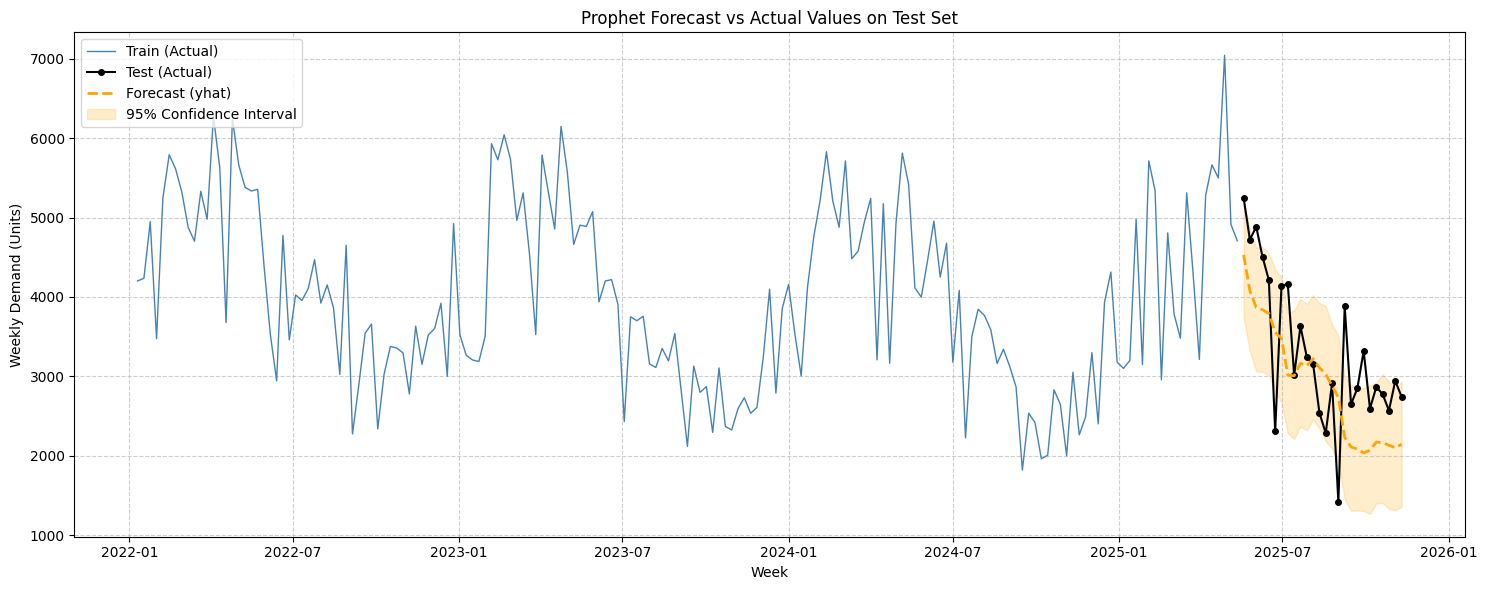


--- Prophet Forecast Components Plot ---


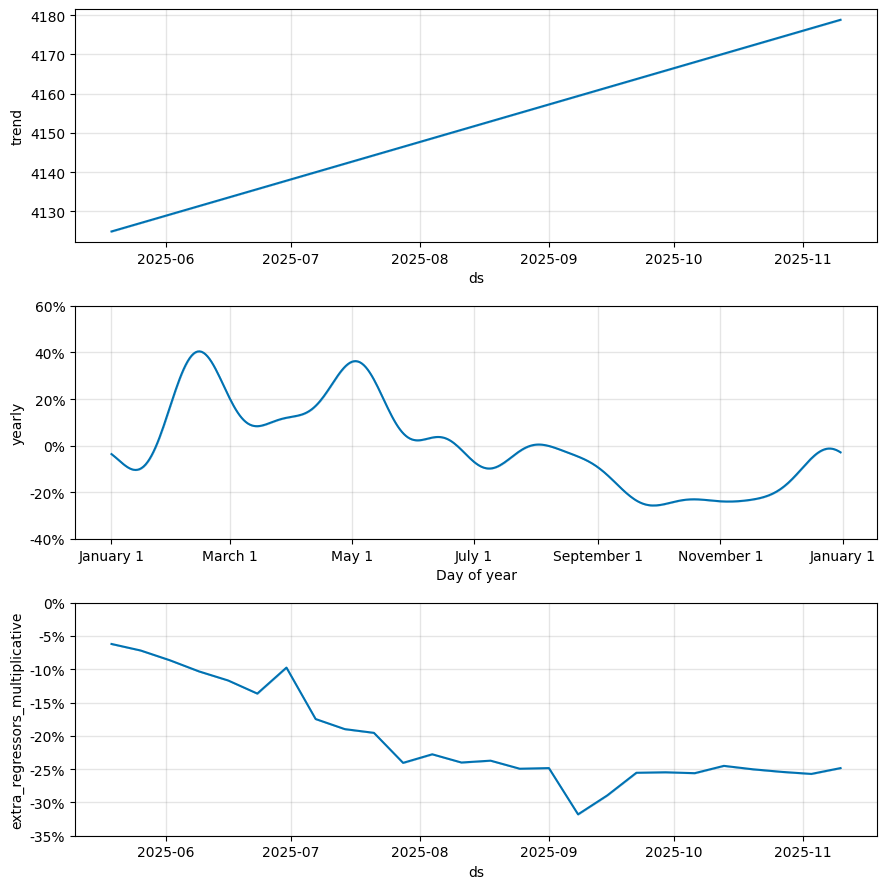

In [ ]:
# --- SECTION 6: MODEL EVALUATION ON TEST SET ---

print("--- Evaluating Model on Test Set ---")
# 'X_test_prophet' (tạo ở Section 4) chính là "DataFrame 3" cho giai đoạn test
# Nó chứa 'ds' và các 'FEATURES' đã được shift
print(f"Making predictions for the test period ({len(X_test_prophet)} weeks)...")

# 1. Chạy dự báo
# m (model đã huấn luyện) dự báo trên X_test_prophet
forecast_test = m.predict(X_test_prophet)

# 2. Gộp kết quả dự báo với giá trị thực tế
eval_df = forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(
    test[['ds', 'y']], on="ds", how="left"
)

print("\n--- Forecast vs Actual (Test Set - First 5 rows) ---")
display(eval_df.head(5))

# 3. Tính toán các chỉ số lỗi
y_true = eval_df["y"].values
y_pred = eval_df["yhat"].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
# Tính MAPE cẩn thận, tránh chia cho 0
epsilon = 1e-8
mape = (np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), epsilon)).mean()) * 100
r2 = r2_score(y_true, y_pred)

print("\n--- Performance Metrics (Test Set) ---")
print(f"MAE  (Lỗi tuyệt đối trung bình):   {mae:.2f}")
print(f"RMSE (Lỗi bình phương trung bình): {rmse:.2f}")
print(f"MAPE (Lỗi phần trăm trung bình): {mape:.2f}%")
print(f"R²   (Hệ số R-squared):             {r2:.3f}")

# 4. Vẽ biểu đồ trực quan hóa
print("\n--- Custom Forecast vs Actual Plot (Train & Test Set) ---")
plt.figure(figsize=(15, 6))

# Dữ liệu Train (Thực tế)
plt.plot(train["ds"], train["y"], label="Train (Actual)", color='steelblue', linewidth=1)

# Dữ liệu Test (Thực tế)
plt.plot(test["ds"], test["y"], label="Test (Actual)", color="black", linewidth=1.5, marker='o', markersize=4)

# Dữ liệu Test (Dự báo)
plt.plot(eval_df["ds"], eval_df["yhat"], label="Forecast (yhat)", color="orange", linewidth=2, linestyle='--')
# Vùng tin cậy 95%
plt.fill_between(eval_df["ds"], eval_df["yhat_lower"], eval_df["yhat_upper"],
                 alpha=0.2, color="orange", label="95% Confidence Interval")

plt.title("Prophet Forecast vs Actual Values on Test Set")
plt.xlabel("Week")
plt.ylabel("Weekly Demand (Units)")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


print("\n--- Prophet Forecast Components Plot ---")
# This breaks down the forecast into trend, seasonality, and regressor effects.
fig2 = m.plot_components(forecast_test)
plt.show()
# --- End of NEW plots ---


--- Error Analysis (Residuals on Test Set) ---


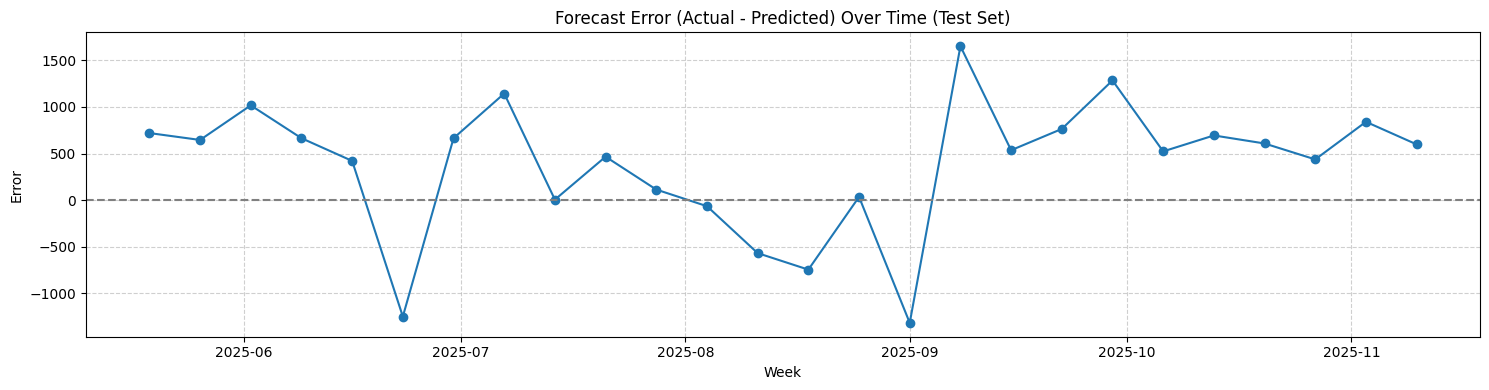


--- Descriptive Statistics of Errors (Test Set) ---


,count,mean,std,min,25%,50%,75%,max
error,26.0,380.823325,710.255316,-1316.139275,55.124094,567.489884,713.785219,1652.317796


In [ ]:
# --- SECTION 7: ERROR ANALYSIS (RESIDUALS) ---

print("--- Error Analysis (Residuals on Test Set) ---")
eval_df["error"] = eval_df["y"] - eval_df["yhat"]

plt.figure(figsize=(15, 4))
plt.plot(eval_df["ds"], eval_df["error"], marker='o', linestyle='-')
plt.axhline(0, color="gray", linestyle="--")
plt.title("Forecast Error (Actual - Predicted) Over Time (Test Set)")
plt.xlabel("Week")
plt.ylabel("Error")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n--- Descriptive Statistics of Errors (Test Set) ---")
display(eval_df["error"].describe().to_frame().T)

In [ ]:
# --- SECTION 8: CROSS-VALIDATION (Optional) ---

DO_CV = True  # Đặt là False để bỏ qua bước này (có thể tốn thời gian)

if DO_CV:
    print("--- Running Time Series Cross-Validation ---")
    from prophet.diagnostics import cross_validation, performance_metrics

    # Bước này có thể mất vài phút
    try:
        # Huấn luyện trên 400 ngày đầu, dự báo 90 ngày tới
        # Sau đó trượt đi 60 ngày, lặp lại
        df_cv = cross_validation(
            m, # model đã huấn luyện trên tập train
            initial="400 days",   # Kích thước tập train ban đầu
            period="60 days",     # Trượt đi 60 ngày
            horizon="90 days"     # Dự báo cho 90 ngày tới
        )

        print("\n--- Cross-Validation Performance Metrics (Aggregated) ---")
        df_p = performance_metrics(df_cv)
        display(df_p.head())

    except Exception as e:
        print(f"⚠️ Cross-validation failed: {e}")
else:
    print("--- Cross-Validation Skipped ---")

--- Running Time Series Cross-Validation ---


INFO:prophet:Making 13 forecasts with cutoffs between 2023-02-22 00:00:00 and 2025-02-11 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]


--- Cross-Validation Performance Metrics (Aggregated) ---


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,1.595975e+06,1263.319230,1010.988230,0.264194,0.200439,0.236699,0.4375
1,10 days,1.631372e+06,1277.251755,1030.846712,0.287852,0.232645,0.253401,0.3750
2,11 days,1.676536e+06,1294.811058,1025.919299,0.307592,0.201498,0.263501,0.3750
3,12 days,1.750232e+06,1322.963213,1090.860369,0.314676,0.201498,0.271623,0.2500
4,13 days,1.671581e+06,1292.896391,1082.658704,0.307059,0.212699,0.267739,0.2500


--- Generating Future Forecast ---
✅ Đã tải thành công '03_future_dataframe.csv' (Input cho 16 tuần tới).
Retraining model on the FULL dataset (df)...
✅ Model retrained on full data.
Scaling future DataFrame (DataFrame 3) using the *same* scaler from training...
✅ Scaling DataFrame 3 thành công.
Making future predictions on SCALED data...

--- Future Forecast (First 5 rows) ---


,ds,yhat,yhat_lower,yhat_upper
0,2025-11-17,2686.603382,1907.687258,3476.442240
1,2025-11-24,2790.737482,2019.317199,3570.420925
2,2025-12-01,2986.832373,2203.593881,3730.799741
3,2025-12-08,3263.789255,2507.305966,4146.417788
4,2025-12-15,3569.923068,2749.358993,4340.172168


✅ Đã lưu kết quả dự báo vào: /content/drive/MyDrive/Denso/Data_Structure/04_final_forecast_output.csv

--- Plotting Historical Data and Future Forecast ---


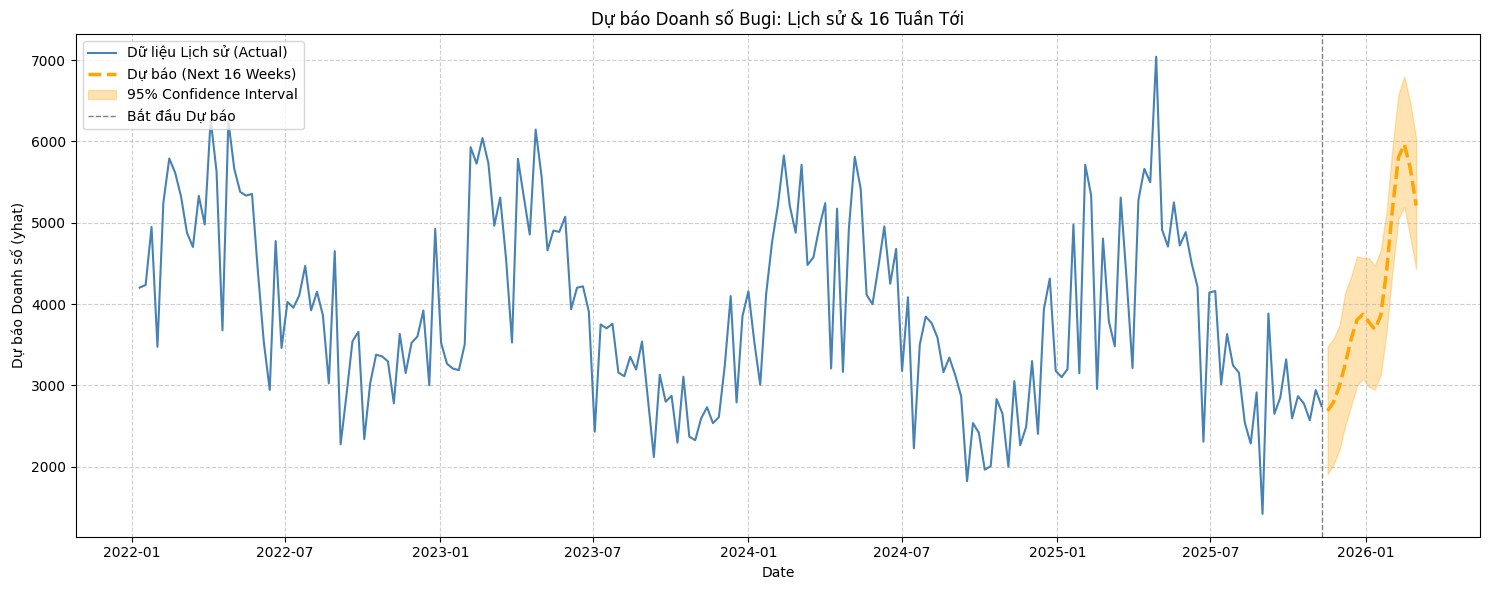

In [ ]:
# --- SECTION 9: FUTURE FORECASTING (ĐÃ SỬA LỖI SCALING) ---

print("--- Generating Future Forecast ---")
FORECAST_WEEKS = 16  # Dự báo cho 16 tuần tới

# --- 1. Tải DataFrame 3 (Input) ---
# Đây là file mà notebook "03_Generate_Future_DataFrame.ipynb" đã tạo ra
FUTURE_INPUT_PATH = os.path.join(BASE_DRIVE_PATH, "03_future_dataframe.csv")
try:
    future_df_input = pd.read_csv(FUTURE_INPUT_PATH, parse_dates=["ds"])
    print(f"✅ Đã tải thành công '03_future_dataframe.csv' (Input cho 16 tuần tới).")
except FileNotFoundError:
    print(f"❌ LỖI: Không tìm thấy file '{FUTURE_INPUT_PATH}'.")
    print("Vui lòng chạy notebook '03_Generate_Future_DataFrame.ipynb' trước.")
    raise

# --- 2. Huấn luyện lại Model trên TOÀN BỘ Dữ liệu ---
# 'df' là DataFrame đầy đủ, đã xử lý (từ Section 3)
# 'FEATURES' là danh sách feature (từ Section 3)
# 'scaler' là đối tượng scaler (từ Section 3)
print("Retraining model on the FULL dataset (df)...")

m_full = Prophet(
    yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False,
    seasonality_mode="multiplicative", changepoint_prior_scale=0.5
)
if FEATURES:
    for f in FEATURES:
        m_full.add_regressor(f, prior_scale=0.1)

# Fit trên 'df' (toàn bộ lịch sử ĐÃ ĐƯỢC SCALE)
m_full.fit(df)
print("✅ Model retrained on full data.")


# --- 3. SỬA LỖI: SCALE DỮ LIỆU TƯƠNG LAI ---
# 'scaler' là đối tượng bạn đã tạo và 'fit' ở Section 3
# 'FEATURES' là danh sách các feature bạn đã tạo ở Section 3
try:
    print("Scaling future DataFrame (DataFrame 3) using the *same* scaler from training...")

    # DÙNG 'scaler' ĐÃ HUẤN LUYỆN ĐỂ BIẾN ĐỔI (TRANSFORM) DỮ LIỆU MỚI
    # Điều này đảm bảo 'future_df_input' có cùng
    # thang đo (scale) với dữ liệu đã huấn luyện (df)
    future_df_input[FEATURES] = scaler.transform(future_df_input[FEATURES])

    print("✅ Scaling DataFrame 3 thành công.")
except NameError:
    print("❌ LỖI: Không tìm thấy 'scaler' hoặc 'FEATURES'. Vui lòng chạy lại Section 3.")
    raise
except Exception as e:
    print(f"❌ LỖI khi scaling DataFrame 3: {e}")
    raise

# --- 4. Chạy Dự báo Tương lai (TRÊN DỮ LIỆU ĐÃ SCALE) ---
print("Making future predictions on SCALED data...")
# Model (m_full) dự báo trên DataFrame 3 (ĐÃ ĐƯỢC SCALE)
forecast_future = m_full.predict(future_df_input)

# --- 5. Trích xuất & Lưu Kết quả ---
out_future = forecast_future[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()

print("\n--- Future Forecast (First 5 rows) ---")
display(out_future.head()) # Bây giờ sẽ hiển thị số hợp lý

# --- 6. Lưu file & Vẽ Biểu đồ (Giữ nguyên) ---
FORECAST_OUTPUT_PATH = os.path.join(BASE_DRIVE_PATH, "04_final_forecast_output.csv")
try:
    out_future.to_csv(FORECAST_OUTPUT_PATH, index=False)
    print(f"✅ Đã lưu kết quả dự báo vào: {FORECAST_OUTPUT_PATH}")
except Exception as e:
    print(f"⚠️ Không thể lưu file dự báo: {e}")

print("\n--- Plotting Historical Data and Future Forecast ---")
plt.figure(figsize=(15, 6))
plt.plot(df["ds"], df["y"], label="Dữ liệu Lịch sử (Actual)", color="steelblue", linewidth=1.5)
plt.plot(out_future["ds"], out_future["yhat"], color="orange", label=f"Dự báo (Next {FORECAST_WEEKS} Weeks)", linewidth=2.5, linestyle='--')
plt.fill_between(
    out_future["ds"],
    out_future["yhat_lower"],
    out_future["yhat_upper"],
    color="orange",
    alpha=0.3,
    label="95% Confidence Interval"
)
plt.axvline(df["ds"].max(), color="gray", linestyle="--", linewidth=1, label="Bắt đầu Dự báo")
plt.title(f"Dự báo Doanh số Bugi: Lịch sử & {FORECAST_WEEKS} Tuần Tới")
plt.xlabel("Date")
plt.ylabel("Dự báo Doanh số (yhat)")
plt.legend(loc="upper left")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()